* Emotion Label: 1: Surprise / 2: Fear / 3: Disgust / 4: Happiness / 5: Sadness / 6: Anger / 7: Neutral
* emotional_classes = ["Surprise", "Fear", "Disgust", "Happiness", "Sadness", "Anger", "Neutral"]

# Data Preparation

In [1]:
#Check Nvidia GPU
! nvidia-smi

Thu Apr  7 14:26:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:01:00.0 Off |                    0 |
|  0%   53C    P0    64W / 300W |      4MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:25:00.0 Off |                    0 |
|  0%   

In [2]:
#Import Packages
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import re
from sklearn.utils import shuffle
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import cv2

from skimage.transform import resize

In [3]:
#GPU Configuration
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
#Check Package Version
print(cv2.__version__)
print(tf.__version__)

4.5.4
2.6.0


In [5]:
#Check Current Directory
os.getcwd()

'/Data'

In [6]:
t = datetime.datetime.now()
t = t.strftime('%Y%m%d')

In [7]:
#Define Directory of Images
data_path_images = '/Data/RAF_DB/Basic_Emotion/basic/Image/aligned'
data_dir_list_images = os.listdir(data_path_images)

In [8]:
#Define Directory of Labels
data_path_labels = '/Data/RAF_DB/Basic_Emotion/basic/EmoLabel'
data_dir_list_labels = os.listdir(data_path_labels)

In [9]:
#Count Subjects
print(len(data_dir_list_labels))
print(len(data_dir_list_images))

1
15339


In [10]:
#Check Element
data_dir_list_labels

['list_patition_label.txt']

In [11]:
#Check Elements
data_dir_list_images[0:10]

['train_05783_aligned.jpg',
 'train_12218_aligned.jpg',
 'train_01722_aligned.jpg',
 'test_1086_aligned.jpg',
 'train_01540_aligned.jpg',
 'train_09677_aligned.jpg',
 'train_04773_aligned.jpg',
 'test_2647_aligned.jpg',
 'train_04718_aligned.jpg',
 'test_1992_aligned.jpg']

In [12]:
#Sort Elements
data_dir_list_labels.sort()
data_dir_list_images.sort()

In [13]:
#Check Elements
data_dir_list_images[0:10]

['test_0001_aligned.jpg',
 'test_0002_aligned.jpg',
 'test_0003_aligned.jpg',
 'test_0004_aligned.jpg',
 'test_0005_aligned.jpg',
 'test_0006_aligned.jpg',
 'test_0007_aligned.jpg',
 'test_0008_aligned.jpg',
 'test_0009_aligned.jpg',
 'test_0010_aligned.jpg']

In [14]:
#Read Label Elements
with open(data_path_labels + '/list_patition_label.txt') as f:
    label_lines=f.readlines()

In [15]:
#Check Label Elements
label_lines[0:5]

['train_00001.jpg 5\n',
 'train_00002.jpg 5\n',
 'train_00003.jpg 4\n',
 'train_00004.jpg 4\n',
 'train_00005.jpg 5\n']

In [16]:
#Sort Label Elements
label_lines.sort()

In [17]:
#Check Label Elements
label_lines[0:5]

['test_0001.jpg 5\n',
 'test_0002.jpg 1\n',
 'test_0003.jpg 4\n',
 'test_0004.jpg 1\n',
 'test_0005.jpg 5\n']

In [18]:
#Collect Label Elements
label_elements=[]

for i in label_lines:
    #print(i)
    #print(i.split(".jpg"))
    #print(i.split(".jpg")[1][1])
    label_elements.append(int(i.split(".jpg")[1][1]))

In [19]:
#Check Elements before Deduction (Index Adaption)
label_elements[0:5]

[5, 1, 4, 1, 5]

In [20]:
#Deduct -1 in order to adapt Python Index
labels = [element - 1 for element in label_elements]

In [21]:
#Show entries after Deduction
labels[0:5]

[4, 0, 3, 0, 4]

In [22]:
#Surprise-0, Fear-1, Disgust-2, Happiness-3, Sadness-4, Anger-5, Neutral-6
emotional_classes = ["Surprise", "Fear", "Disgust", "Happiness", "Sadness", "Anger", "Neutral"]

In [23]:
#Check Amount of Labels
len(labels)

15339

In [24]:
#Check Label Elements
labels[0:10]

[4, 0, 3, 0, 4, 4, 2, 0, 3, 3]

Sadness


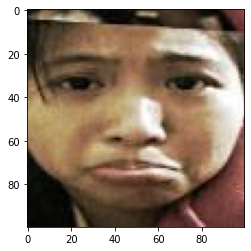

Surprise


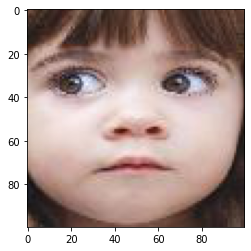

Happiness


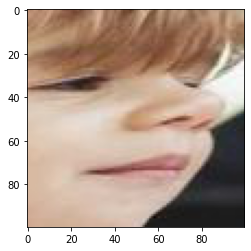

Surprise


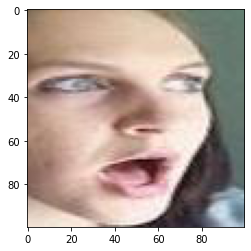

Sadness


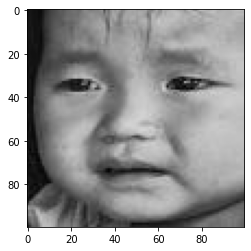

In [25]:
#Cross-Check Labels and Pictures
for i in range(0, 5):
    input_img=plt.imread(data_path_images + "/"+ data_dir_list_images[i])
    print(emotional_classes[labels[i]])
    plt.imshow(input_img)
    plt.show()

In [26]:
#Collect Images (Features)
images=[]

for i in range(len(data_dir_list_images)):
    input_img=plt.imread(data_path_images + "/"+ data_dir_list_images[i])
    images.append(input_img)
    #print(input_img.dtype)
    #print(input_img.shape)
    #print(input_img)

In [27]:
#Count Features and Labels
print(len(images))
print(len(labels))

15339
15339


In [28]:
#Check Feature Type and Shape
print(images[0].dtype)
print(images[0].shape)

uint8
(100, 100, 3)


In [29]:
print(len(images))
print(len(labels))

15339
15339


### Resizing - Start

In [30]:
#Function to Rescale Images
def rescale_image(img):
    img = resize(img, (48, 48), anti_aliasing=True)
    #img_new = img.astype(np.uint8)
    return img

In [31]:
#Create List of Resized Images with 48 x 48 Pixels
images_resize = [rescale_image(i) for i in images]

In [32]:
images_resize[0].shape

(48, 48, 3)

In [33]:
images_resize[0].dtype

dtype('float64')

Sadness


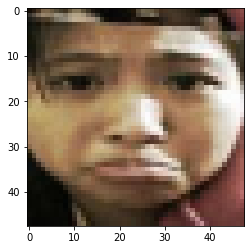

Surprise


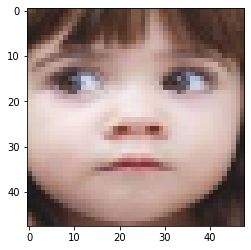

Happiness


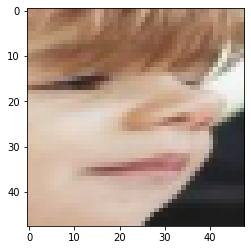

Surprise


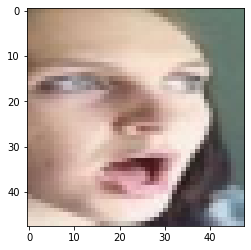

Sadness


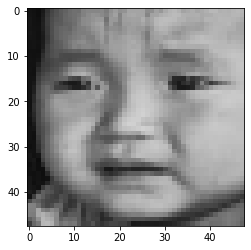

In [34]:
#Cross-Check Labels and Pictures
for i in range(0, 5):
    #input_img=plt.imread(data_path_images + "/"+ data_dir_list_images[i])
    print(emotional_classes[labels[i]])
    plt.imshow(images_resize[i])
    plt.show()

In [35]:
#Check Feature Type and Shape
print(images_resize[0].dtype)
print(images_resize[0].shape)

float64
(48, 48, 3)


In [36]:
#Check Training Data
print(images_resize[0].min())
print(images_resize[0].mean())
print(images_resize[0].max())

0.0038327700251612772
0.41127684331920383
0.9978314701025153


In [37]:
print(len(images_resize))
print(len(labels))

15339
15339


### Resizing - End

# Data Pre-Processing

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
#Identify Training Label Distribution
#Emotion Label: 1: Surprise / 2: Fear / 3: Disgust / 4: Happiness / 5: Sadness / 6: Anger / 7: Neutral
unique, counts = np.unique(labels, return_counts = True)
dict(zip(unique, counts))

{0: 1619, 1: 355, 2: 877, 3: 5957, 4: 2460, 5: 867, 6: 3204}

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(images_resize, labels, test_size=0.2, random_state=1, stratify=labels)
#X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=1, stratify=labels)

In [41]:
#Convert Training Data into Numpy Array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [42]:
print(X_train.shape, Y_train.shape)

(12271, 48, 48, 3) (12271,)


In [43]:
#Convert Valid Data into Numpy Array
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [44]:
print (X_test.shape, Y_test.shape)

(3068, 48, 48, 3) (3068,)


### Split Training Data into Training and Validation Sets

In [45]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, stratify=Y_train)

In [46]:
print(X_train.shape, Y_train.shape)

(8589, 48, 48, 3) (8589,)


In [47]:
#Convert Valid Data into Numpy Array
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [48]:
print(X_val.shape, Y_val.shape)

(3682, 48, 48, 3) (3682,)


In [49]:
#Check Array Shape
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(8589,)
(3682,)
(3068,)


In [50]:
#Identify Training Label Distribution
unique, counts = np.unique(Y_train, return_counts = True)
dict(zip(unique, counts))

{0: 906, 1: 199, 2: 491, 3: 3335, 4: 1378, 5: 486, 6: 1794}

In [51]:
#Identify Training Label Distribution
unique, counts = np.unique(Y_val, return_counts = True)
dict(zip(unique, counts))

{0: 389, 1: 85, 2: 211, 3: 1430, 4: 590, 5: 208, 6: 769}

In [52]:
#Identify Training Label Distribution
unique, counts = np.unique(Y_test, return_counts = True)
dict(zip(unique, counts))

{0: 324, 1: 71, 2: 175, 3: 1192, 4: 492, 5: 173, 6: 641}

In [53]:
#Check unique Label Elements
np.unique(Y_train)

array([0, 1, 2, 3, 4, 5, 6])

In [54]:
#Transform/Categorize Label Elements
print (Y_train.shape)
print (Y_val.shape)
print(Y_test.shape)

Y_train = np_utils.to_categorical(Y_train, 7)
Y_val = np_utils.to_categorical(Y_val, 7)
Y_test = np_utils.to_categorical(Y_test, 7)

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(8589,)
(3682,)
(3068,)
(8589, 7)
(3682, 7)
(3068, 7)


In [55]:
#Check Amount and Shape of Training Data
print(X_train.shape, Y_train.shape)

(8589, 48, 48, 3) (8589, 7)


In [56]:
#Check Amount and Shape of Test Data
print(X_val.shape, Y_val.shape)

(3682, 48, 48, 3) (3682, 7)


In [57]:
print(X_test.shape, Y_test.shape)

(3068, 48, 48, 3) (3068, 7)


Sadness


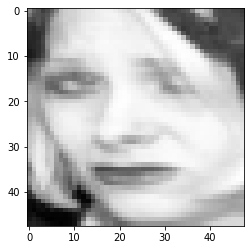

In [58]:
#Cross-Check Input and Output Variable
print(emotional_classes[int(np.where(Y_train[1]==1)[0])])
plt.imshow(X_train[1])
plt.show()

In [59]:
#Check Training Data
print(X_train[0].min())
print(X_train[0].mean())
print(X_train[0].max())

0.0001869821023150057
0.461617980396739
0.9976087414771055


In [60]:
#Normalization of Training Data - here excluded because of resizing
#X_train = X_train / 255
#X_val = X_val / 255
#X_test = X_test / 255

In [61]:
#Check Training Data
print(X_train[0].min())
print(X_train[0].mean())
print(X_train[0].max())

0.0001869821023150057
0.461617980396739
0.9976087414771055


In [62]:
#Check Validation Data
print(X_val[0].min())
print(X_val[0].mean())
print(X_val[0].max())

0.01488476677464122
0.580998094481412
0.9998870092464027


In [63]:
#Check Test Data
print(X_test[0].min())
print(X_test[0].mean())
print(X_test[0].max())

0.0031658442938119155
0.5905536831960155
0.9999992148639866


In [64]:
#Check Training and Test Data
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

print(X_test.shape)
print(Y_test.shape)

(8589, 48, 48, 3)
(8589, 7)
(3682, 48, 48, 3)
(3682, 7)
(3068, 48, 48, 3)
(3068, 7)


# ML Model Building

In [65]:
#Import Package(s)
from tensorflow import keras

In [66]:
#Import Package(s)
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.preprocessing.image import ImageDataGenerator

In [67]:
#Import Package(s)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [68]:
#Build ImageDataGenerator
datagen_train = ImageDataGenerator(
        featurewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_center=False,  
        samplewise_std_normalization=False,  
        #rescale=1/255, #or 1./255 -1 for 8-bit images, rescale by 1/255 to have pixel values in the range 0 and 1
        #zca_whitening=False,  
        #rotation_range=10, #Random Rotation between 0 and 360 degrees, empty areas filled by different techniques, e. g. "nearest" -> nearest pixel values 
        #zoom_range = 20.0, #Randomly Zooms In or Out 
        #width_shift_range=0.1, #Random Horizontal Shifts, float number -> percentage of pixels, integer number -> number of pixels  
        #height_shift_range=0.1, #Random Vertical Shifts, float number -> percentage of pixels, integer number -> number of pixels
        horizontal_flip=False, #Useful only for symmetrical objects
        vertical_flip=False)  #Useful only for symmetrical objects

datagen_valid = ImageDataGenerator()

In [69]:
#Fit ImageDataGenerator
datagen_train.fit(X_train)

In [70]:
#Define Epochs, Batch Size and Steps per Epoch
epochs = 50
batch_size = 128
steps_per_epoch = len(X_train)//batch_size

In [71]:
#Check Epochs, Batch Size and Steps per Epoch
print(epochs)
print(batch_size) 
print(steps_per_epoch)

50
128
67


In [72]:
#Load Training and Validation Generators
train_generator = datagen_train.flow(X_train, Y_train, batch_size=batch_size)
valid_generator = datagen_valid.flow(X_val, Y_val, batch_size=batch_size)

In [73]:
#Check Training Shape
input_shape = X_train.shape[1:4]
print(input_shape)

(48, 48, 3)


In [74]:
#Check Training Data
print(X_train[0].min())
print(X_train[0].mean())
print(X_train[0].max())

0.0001869821023150057
0.461617980396739
0.9976087414771055


In [75]:
#ML Model Building
model = Sequential()

model.add(Conv2D(32, (5, 5), padding="same", activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='softmax'))

2022-04-07 14:26:28.881887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43439 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-04-07 14:26:28.883579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43439 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6


In [76]:
#Check Model Structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       7

In [77]:
#Define Callbacks
my_callbacks = [
    #tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='Model/mdl_raf_vam.hdf5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ReduceLROnPlateau(monitor='val_accuracy',
                      patience=3,
                      factor=0.1,   
                      min_lr=0.000000001,
                      min_delta=0.0001,
                      verbose=1)
]

In [78]:
#Define Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
#opt = tf.keras.optimizers.SGD(learning_rate=0.0001)

In [79]:
#Compile Model
model.compile(loss="categorical_crossentropy", 
              optimizer= opt,
              metrics=['accuracy']
             )

# Model Training

In [80]:
#Train Model
history = model.fit(train_generator,
          epochs=epochs, 
          validation_data=valid_generator,
          callbacks = [my_callbacks],
          verbose=1)

2022-04-07 14:26:29.425617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-07 14:26:30.759524: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2022-04-07 14:26:32.343904: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


68/68 [==============================] - 5s 26ms/step - loss: 1.7667 - accuracy: 0.3465 - val_loss: 1.6637 - val_accuracy: 0.3884

Epoch 00001: val_accuracy improved from -inf to 0.38838, saving model to Model/mdl_raf_vam.hdf5
Epoch 2/50
68/68 [==============================] - 1s 18ms/step - loss: 1.7083 - accuracy: 0.3592 - val_loss: 1.6378 - val_accuracy: 0.3884

Epoch 00002: val_accuracy did not improve from 0.38838
Epoch 3/50
68/68 [==============================] - 1s 15ms/step - loss: 1.6773 - accuracy: 0.3755 - val_loss: 1.6045 - val_accuracy: 0.4071

Epoch 00003: val_accuracy improved from 0.38838 to 0.40712, saving model to Model/mdl_raf_vam.hdf5
Epoch 4/50
68/68 [==============================] - 1s 15ms/step - loss: 1.6197 - accuracy: 0.4092 - val_loss: 1.5748 - val_accuracy: 0.4612

Epoch 00004: val_accuracy improved from 0.40712 to 0.46116, saving model to Model/mdl_raf_vam.hdf5
Epoch 5/50
68/68 [==============================] - 1s 14ms/step - loss: 1.5160 - accuracy: 0.

In [81]:
#Identify Keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

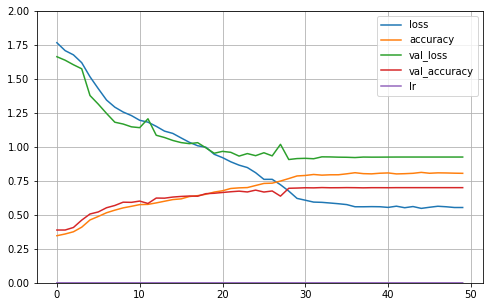

In [82]:
#Visualize Keys
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
#save_fig("keras_learning_curves_plot")
plt.show()

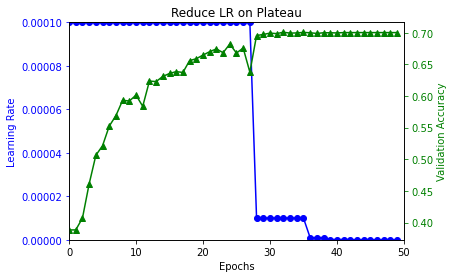

In [83]:
#Visualize LR on Plateau
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, epochs)
plt.gca().set_ylim(0, 0.0001)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_accuracy"], "g^-")
ax2.set_ylabel('Validation Accuracy', color='g')
ax2.tick_params('y', colors='g')

plt.title("Reduce LR on Plateau", fontsize=12)
plt.show()

# Model Evaluation

## Evaluation with Last Trained Model

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [85]:
print(X_test.shape, Y_test.shape)

(3068, 48, 48, 3) (3068, 7)


In [86]:
#Predict Labels for Test Set
preds = model.predict(X_test)

In [87]:
#Check Predictions
preds

array([[1.0208184e-06, 6.0377471e-07, 8.6545679e-06, ..., 5.8054507e-06,
        8.4459543e-06, 1.4010496e-06],
       [1.0581634e-02, 1.6117386e-03, 6.8409145e-02, ..., 4.9896041e-01,
        2.1497216e-03, 4.1644013e-01],
       [2.2167927e-02, 2.7970711e-03, 1.1262065e-02, ..., 7.4361145e-01,
        1.2657251e-03, 2.1649931e-01],
       ...,
       [3.0163309e-02, 1.7106270e-03, 2.3944633e-02, ..., 2.1106364e-01,
        1.2409426e-03, 7.3064542e-01],
       [3.0973977e-01, 1.3379343e-02, 5.7692886e-03, ..., 2.7542496e-01,
        2.8701555e-03, 3.8043207e-01],
       [3.4126151e-01, 2.1376273e-02, 7.6794289e-02, ..., 1.2925017e-01,
        3.4078512e-01, 7.0000790e-02]], dtype=float32)

In [88]:
#Check Predictions
len(preds)

3068

In [89]:
#Check True Labels
Y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [90]:
#Check Predictions' Shape
preds.shape

(3068, 7)

In [91]:
#Function to Get Single Prediction Class
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))
  
  for i in range(len(preds)):
    pred_class[i] = np.argmax(preds[i])
  
  return pred_class

In [92]:
#Get Single Prediction Class
predicted_class = get_class(preds)

In [93]:
#Check Single Prediction Classes
predicted_class[0:10]

array([[3.],
       [4.],
       [4.],
       [5.],
       [4.],
       [0.],
       [3.],
       [6.],
       [3.],
       [4.]])

In [94]:
#Check Shape of Single Prediction Classes
predicted_class.shape

(3068, 1)

In [95]:
#Check Shape of True Classes
Y_test.shape

(3068, 7)

In [96]:
#Get Single True Class
Y_test = Y_test.argmax(axis=1)

In [97]:
#Check Single True Class
Y_test

array([3, 6, 4, ..., 6, 6, 0])

In [98]:
#Create Confusion Matrix
cm = confusion_matrix(Y_test, predicted_class)

In [99]:
#Show Confusion Matrix
cm

array([[ 226,    2,    1,   23,   16,   11,   45],
       [  13,   18,    0,   12,   14,    7,    7],
       [   7,    0,   42,   24,   29,   20,   53],
       [  16,    3,    6, 1070,   39,   15,   43],
       [  23,    4,    9,   52,  259,   21,  124],
       [  19,    3,    8,   22,   17,   91,   13],
       [  26,    0,   13,   40,   66,   12,  484]])

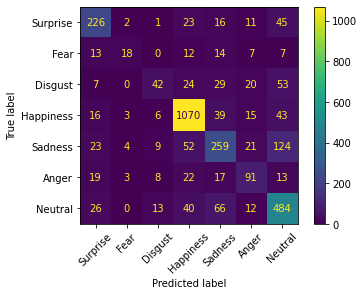

In [100]:
#Show Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(Y_test, predicted_class, display_labels=emotional_classes, xticks_rotation=45)
plt.show()

In [101]:
#Show Valuation Metrics
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test, predicted_class)))

print('Micro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test, predicted_class, average='weighted')))


Accuracy: 0.71

Micro Precision: 0.71
Micro Recall: 0.71
Micro F1-score: 0.71

Macro Precision: 0.63
Macro Recall: 0.56
Macro F1-score: 0.57

Weighted Precision: 0.71
Weighted Recall: 0.71
Weighted F1-score: 0.70


In [102]:
#Check Emotional Classes
emotional_classes

['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']

In [103]:
#Show Classification Report
print('\nClassification Report\n')
print(classification_report(Y_test, predicted_class, target_names=emotional_classes))


Classification Report

              precision    recall  f1-score   support

    Surprise       0.68      0.70      0.69       324
        Fear       0.60      0.25      0.36        71
     Disgust       0.53      0.24      0.33       175
   Happiness       0.86      0.90      0.88      1192
     Sadness       0.59      0.53      0.56       492
       Anger       0.51      0.53      0.52       173
     Neutral       0.63      0.76      0.69       641

    accuracy                           0.71      3068
   macro avg       0.63      0.56      0.57      3068
weighted avg       0.71      0.71      0.70      3068



In [104]:
clf_report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predicted_class, target_names=emotional_classes, output_dict=True)).transpose()
clf_report

precision    recall  f1-score     support
Surprise       0.684848  0.697531  0.691131   324.00000
Fear           0.600000  0.253521  0.356436    71.00000
Disgust        0.531646  0.240000  0.330709   175.00000
Happiness      0.860821  0.897651  0.878850  1192.00000
Sadness        0.588636  0.526423  0.555794   492.00000
Anger          0.514124  0.526012  0.520000   173.00000
Neutral        0.629389  0.755070  0.686525   641.00000
accuracy       0.713820  0.713820  0.713820     0.71382
macro avg      0.629923  0.556601  0.574206  3068.00000
weighted avg   0.705873  0.713820  0.703445  3068.00000

In [105]:
clf_report.to_csv('RAF_DB/Basic_Emotion/basic/Classification_Report/{}_Classfication_Report_RAF-DB_lastTrainedModel_resized_run.csv'.format(t), sep=',', index= True)

In [106]:
print('{}_Classfication_Report_RAF-DB_lastTrainedModel_resized_run.csv'.format(t))

20220407_Classfication_Report_RAF-DB_lastTrainedModel_resized_run.csv


## Evaluation with Model Having Highest Val_Accuracy

In [107]:
print(X_test.shape, Y_test.shape)

(3068, 48, 48, 3) (3068,)


In [108]:
#Load Model with Lowest Val_Loss
model = keras.models.load_model('Model/mdl_raf_vam.hdf5') #model including optimizer state
#model = model.load_weights(checkpoint_filepath) #model, but state of the optimizer is discarded

In [109]:
#Predict Labels for Test Set
preds = model.predict(X_test)

In [110]:
#Check Predictions
preds

array([[8.0227221e-07, 4.6463936e-07, 6.2877966e-06, ..., 4.7763056e-06,
        5.3573872e-06, 1.0896977e-06],
       [1.0350367e-02, 1.3350357e-03, 5.8578383e-02, ..., 5.2292097e-01,
        1.7117204e-03, 4.0334028e-01],
       [1.8291797e-02, 2.8608802e-03, 9.0416782e-03, ..., 8.0071145e-01,
        1.2621243e-03, 1.6517600e-01],
       ...,
       [2.5844054e-02, 1.8447613e-03, 2.6604226e-02, ..., 2.2345905e-01,
        1.2469708e-03, 7.1962106e-01],
       [2.9333165e-01, 1.3777729e-02, 5.5765398e-03, ..., 3.2073867e-01,
        2.7264070e-03, 3.5039577e-01],
       [3.5075313e-01, 2.5284521e-02, 6.6063300e-02, ..., 1.2710318e-01,
        3.6177242e-01, 5.1259782e-02]], dtype=float32)

In [111]:
#Check Predictions
len(preds)

3068

In [112]:
#Check True Labels
Y_test

array([3, 6, 4, ..., 6, 6, 0])

In [113]:
#Check Predictions' Shape
preds.shape

(3068, 7)

In [114]:
#Function to Get Single Prediction Class
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))
  
  for i in range(len(preds)):
    pred_class[i] = np.argmax(preds[i])
  
  return pred_class

In [115]:
#Get Single Prediction Class
predicted_class = get_class(preds)

In [116]:
#Check Single Prediction Classes
predicted_class[0:10]

array([[3.],
       [4.],
       [4.],
       [5.],
       [4.],
       [0.],
       [3.],
       [6.],
       [3.],
       [4.]])

In [117]:
#Check Shape of Single Prediction Classes
predicted_class.shape

(3068, 1)

In [118]:
#Check Shape of True Classes
Y_test.shape

(3068,)

In [119]:
#Check Single True Class
Y_test

array([3, 6, 4, ..., 6, 6, 0])

In [120]:
#Create Confusion Matrix
cm = confusion_matrix(Y_test, predicted_class)

In [121]:
#Show Confusion Matrix
cm

array([[ 223,    2,    1,   26,   17,   11,   44],
       [  12,   18,    0,   12,   15,    7,    7],
       [   8,    0,   40,   26,   33,   20,   48],
       [  16,    3,    5, 1072,   41,   15,   40],
       [  23,    5,    9,   54,  274,   20,  107],
       [  20,    4,    7,   22,   17,   89,   14],
       [  29,    0,   13,   42,   75,   11,  471]])

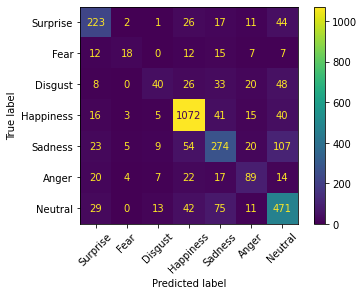

In [122]:
#Show Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(Y_test, predicted_class, display_labels=emotional_classes, xticks_rotation=45)
plt.show()

In [123]:
#Show Valuation Metrics
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test, predicted_class)))

print('Micro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(Y_test, predicted_class, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(Y_test, predicted_class, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test, predicted_class, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test, predicted_class, average='weighted')))


Accuracy: 0.71

Micro Precision: 0.71
Micro Recall: 0.71
Micro F1-score: 0.71

Macro Precision: 0.62
Macro Recall: 0.55
Macro F1-score: 0.57

Weighted Precision: 0.70
Weighted Recall: 0.71
Weighted F1-score: 0.70


In [124]:
#Check Emotional Classes
emotional_classes

['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']

In [125]:
#Show Classification Report
print('\nClassification Report\n')
print(classification_report(Y_test, predicted_class, target_names=emotional_classes))


Classification Report

              precision    recall  f1-score   support

    Surprise       0.67      0.69      0.68       324
        Fear       0.56      0.25      0.35        71
     Disgust       0.53      0.23      0.32       175
   Happiness       0.85      0.90      0.88      1192
     Sadness       0.58      0.56      0.57       492
       Anger       0.51      0.51      0.51       173
     Neutral       0.64      0.73      0.69       641

    accuracy                           0.71      3068
   macro avg       0.62      0.55      0.57      3068
weighted avg       0.70      0.71      0.70      3068



In [126]:
clf_report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predicted_class, target_names=emotional_classes, output_dict=True)).transpose()
clf_report

precision    recall  f1-score      support
Surprise       0.673716  0.688272  0.680916   324.000000
Fear           0.562500  0.253521  0.349515    71.000000
Disgust        0.533333  0.228571  0.320000   175.000000
Happiness      0.854864  0.899329  0.876533  1192.000000
Sadness        0.580508  0.556911  0.568465   492.000000
Anger          0.514451  0.514451  0.514451   173.000000
Neutral        0.644323  0.734789  0.686589   641.000000
accuracy       0.712842  0.712842  0.712842     0.712842
macro avg      0.623385  0.553692  0.570924  3068.000000
weighted avg   0.703447  0.712842  0.702428  3068.000000

In [127]:
clf_report.to_csv('RAF_DB/Basic_Emotion/basic/Classification_Report/{}_Classfication_Report_RAF-DB_bestTrainedModel_resized_run.csv'.format(t), sep=',', index= True)

In [128]:
print('{}_Classfication_Report_RAF-DB_bestTrainedModel_resized_run.csv'.format(t))

20220407_Classfication_Report_RAF-DB_bestTrainedModel_resized_run.csv
